<a href="https://colab.research.google.com/github/fziilk/WQ-Model-3-NN/blob/master/KARTUL_ENV_Water_Quality_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi Air Layak Minum vs Tidak Layak Minum dengan Artificial Neural Network

## Preparasi

### Import Library yang Dibutuhkan

In [1]:
!pip install scikeras

In [2]:
try:
    # utils
    import pandas as pd
    import numpy as np
    import shutil
    from zipfile import ZipFile
    import os
    from IPython.display import display
    import json
    import pickle
    from tqdm import tqdm_notebook

    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import classification_report, accuracy_score

    # plotting tools
    import matplotlib
    from matplotlib import pyplot as plt
    import seaborn as sns

    # modeling
    import tensorflow as tf
    import keras

    from keras import Sequential
    from keras.layers import add
    from keras.utils import plot_model
    from keras.layers import Dropout, Dense
    from keras.layers import BatchNormalization
    from scikeras.wrappers import KerasClassifier
    from imblearn.pipeline import Pipeline as ImbPipeline

    ## creating a baseline
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.compose import ColumnTransformer
    from sklearn.impute import SimpleImputer
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.metrics import roc_auc_score
    from sklearn.inspection import permutation_importance
    from keras.models import load_model

    print(f"Using tensorflow v{tf.__version__}")
    print(f"Using keras v{keras.__version__}")
    print(f"Using matplotlib v{matplotlib.__version__}")
except Exception:
    import sys
    exc_type, exc_obj, exc_tb = sys.exc_info()
    raise Exception(f"error on importing dependencies! Error on line: {exc_tb.tb_lineno}")
finally:
    print("\nsuccess on importing dependencies!")

Using tensorflow v2.19.0
Using keras v3.10.0
Using matplotlib v3.10.0

success on importing dependencies!


In [3]:
def kaggle(origin_path: str, dataset_urls=None, copy=True):
    root_dir = "/root/.kaggle"
    file_name = "kaggle.json"
    file_loc = os.path.join(root_dir, file_name)

    if not os.path.isdir(root_dir):
        os.mkdir(root_dir)

    if copy:
        shutil.copy(origin_path, root_dir)
    else:
        shutil.move(origin_path, root_dir)

    os.chmod(file_loc, 600)
    print(f"'kaggle.json' file has been copied to {file_loc}!")

    if dataset_urls is not None:
        from kaggle.api.kaggle_api_extended import KaggleApi

        api = KaggleApi()
        api.authenticate()

        for dataset in dataset_urls:
            api.dataset_download_cli(dataset)

        print(f"Dataset has been successfully downloaded!")

def unzip(path: str, del_src: bool):
    zip_ref = ZipFile(path, 'r')
    zip_ref.extractall(os.getcwd())
    zip_ref.close()

    if del_src:
        os.remove(path)

    print(f"\"{path}\" has been extracted!")

def ws_setup(ws_name: str, data_origins: list):
    loc = os.getcwd()
    ws_path = os.path.join(loc, ws_name)

    if not os.path.isdir(ws_path):
        os.mkdir(ws_path)
    else:
        raise Exception(f"\"{ws_name}\" directory already exists!")

    for data in data_origins:
        shutil.move(data, ws_path)

    os.chdir(ws_path)

    print(f"current workspace directory \"{os.getcwd()}\"")

def cor(dataframe, save_fig=False):
    plt.figure(figsize=(10, 8))

    corr_matrix = df.corr().round(2)
    sns.heatmap(data=corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title("Korelasi Antar Parameter", size=20)

    if save_fig:
        plt.savefig("corelation.png")

### Mendapatkan Dataset

In [4]:
from google.colab import files

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fachriz","key":"51d23ded5fc44efb94460eda70716dfc"}'}

In [6]:
kaggle("/content/kaggle.json", ["adityakadiwal/water-potability"], copy=False)

'kaggle.json' file has been copied to /root/.kaggle/kaggle.json!
Dataset URL: https://www.kaggle.com/datasets/adityakadiwal/water-potability
License(s): CC0-1.0


100%|██████████| 251k/251k [00:00<00:00, 134MB/s]


Dataset has been successfully downloaded!


In [7]:
unzip("/content/water-potability.zip", os.getcwd())

"/content/water-potability.zip" has been extracted!


In [8]:
df = pd.read_csv("/content/water_potability.csv")
display(df)

ph    Hardness        Solids  Chloramines     Sulfate  \
0          NaN  204.890455  20791.318981     7.300212  368.516441   
1     3.716080  129.422921  18630.057858     6.635246         NaN   
2     8.099124  224.236259  19909.541732     9.275884         NaN   
3     8.316766  214.373394  22018.417441     8.059332  356.886136   
4     9.092223  181.101509  17978.986339     6.546600  310.135738   
...        ...         ...           ...          ...         ...   
3271  4.668102  193.681735  47580.991603     7.166639  359.948574   
3272  7.808856  193.553212  17329.802160     8.061362         NaN   
3273  9.419510  175.762646  33155.578218     7.350233         NaN   
3274  5.126763  230.603758  11983.869376     6.303357         NaN   
3275  7.874671  195.102299  17404.177061     7.509306         NaN   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       564.308654       10.379783        86.990970   2.963135           0  
1       592.885359       15.180013        56.329076   4.500656           0  
2       418.606213       16.868637        66.420093   3.055934           0  
3       363.266516       18.436524       100.341674   4.628771           0  
4       398.410813       11.558279        31.997993   4.075075           0  
...            ...             ...              ...        ...         ...  
3271    526.424171       13.894419        66.687695   4.435821           1  
3272    392.449580       19.903225              NaN   2.798243           1  
3273    432.044783       11.039070        69.845400   3.298875           1  
3274    402.883113       11.168946        77.488213   4.708658           1  
3275    327.459760       16.140368        78.698446   2.309149           1  

[3276 rows x 10 columns]

In [9]:
a = {'ph': 'ph',
     'Hardness': 'Kesadahan',
     'Solids': 'TDS',
     'Chloramines': 'Kloramina',
     'Sulfate': 'Sulfat',
     'Conductivity': 'Konduktivitas',
     'Organic_carbon': 'Total_organic_carbon',
     'Turbidity': 'Kekeruhan'}

df = df.rename(columns=a)

In [10]:
display(df)

ph   Kesadahan           TDS  Kloramina      Sulfat  \
0          NaN  204.890455  20791.318981   7.300212  368.516441   
1     3.716080  129.422921  18630.057858   6.635246         NaN   
2     8.099124  224.236259  19909.541732   9.275884         NaN   
3     8.316766  214.373394  22018.417441   8.059332  356.886136   
4     9.092223  181.101509  17978.986339   6.546600  310.135738   
...        ...         ...           ...        ...         ...   
3271  4.668102  193.681735  47580.991603   7.166639  359.948574   
3272  7.808856  193.553212  17329.802160   8.061362         NaN   
3273  9.419510  175.762646  33155.578218   7.350233         NaN   
3274  5.126763  230.603758  11983.869376   6.303357         NaN   
3275  7.874671  195.102299  17404.177061   7.509306         NaN   

      Konduktivitas  Total_organic_carbon  Trihalomethanes  Kekeruhan  \
0        564.308654             10.379783        86.990970   2.963135   
1        592.885359             15.180013        56.329076   4.500656   
2        418.606213             16.868637        66.420093   3.055934   
3        363.266516             18.436524       100.341674   4.628771   
4        398.410813             11.558279        31.997993   4.075075   
...             ...                   ...              ...        ...   
3271     526.424171             13.894419        66.687695   4.435821   
3272     392.449580             19.903225              NaN   2.798243   
3273     432.044783             11.039070        69.845400   3.298875   
3274     402.883113             11.168946        77.488213   4.708658   
3275     327.459760             16.140368        78.698446   2.309149   

      Potability  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
3271           1  
3272           1  
3273           1  
3274           1  
3275           1  

[3276 rows x 10 columns]

### Mengeksplor Data

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ph                    2785 non-null   float64
 1   Kesadahan             3276 non-null   float64
 2   TDS                   3276 non-null   float64
 3   Kloramina             3276 non-null   float64
 4   Sulfat                2495 non-null   float64
 5   Konduktivitas         3276 non-null   float64
 6   Total_organic_carbon  3276 non-null   float64
 7   Trihalomethanes       3114 non-null   float64
 8   Kekeruhan             3276 non-null   float64
 9   Potability            3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [12]:
n_null = 0
for a in df.columns:
    print(f'nilai null pada kolom [{a}]: {df[a].isna().sum()}')
    n_null = n_null + df[a].isna().sum()

print(f'\ntotal nilai null pada dataset: {n_null}')

nilai null pada kolom [ph]: 491
nilai null pada kolom [Kesadahan]: 0
nilai null pada kolom [TDS]: 0
nilai null pada kolom [Kloramina]: 0
nilai null pada kolom [Sulfat]: 781
nilai null pada kolom [Konduktivitas]: 0
nilai null pada kolom [Total_organic_carbon]: 0
nilai null pada kolom [Trihalomethanes]: 162
nilai null pada kolom [Kekeruhan]: 0
nilai null pada kolom [Potability]: 0

total nilai null pada dataset: 1434


#### Keseimbangan Dataset

/tmp/ipython-input-415494629.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Potability", data=df, palette='husl');


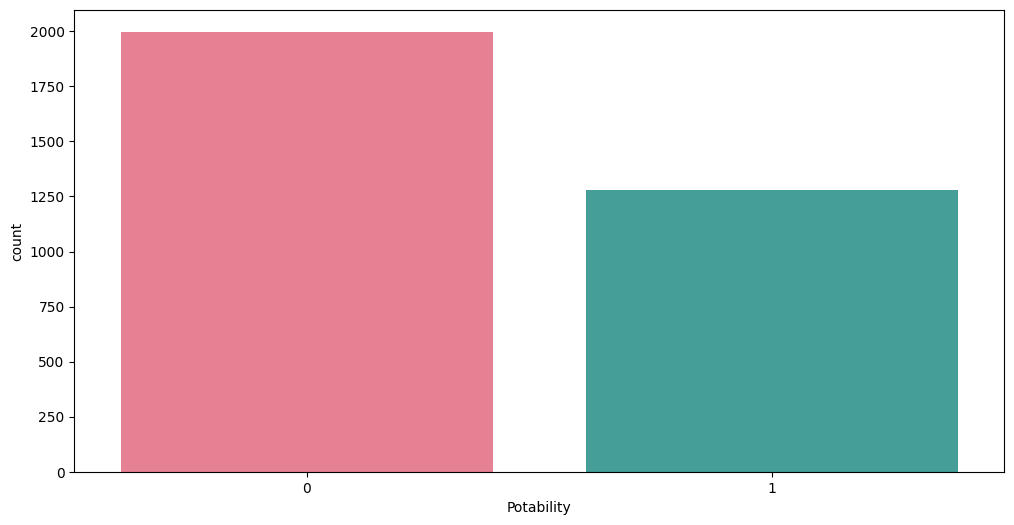

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(x="Potability", data=df, palette='husl');

#### Korelasi antar Fitur

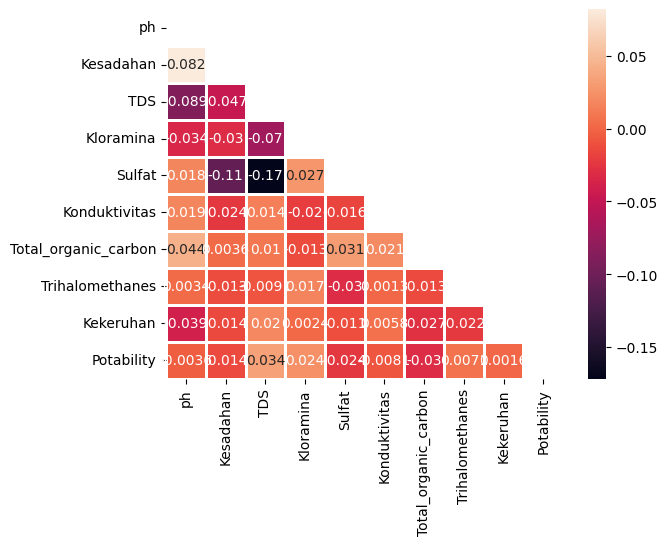

In [14]:
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True,linewidth=.8, mask=matrix, cmap="rocket");

#### Distribusi Masing-Masing Fitur
Hal ini dibutuhkan sebagai acuan mengenai adanya data outlier.

In [15]:
def distributionPlot(dataset):
    fig = plt.figure(figsize=(20, 20))
    for i in tqdm_notebook(range(0, len(dataset.columns)), desc = 'Your plots are being ready'):
        fig.add_subplot(int(np.ceil(len(dataset.columns)/3)), 3, i+1)
        sns.distplot(
            dataset.iloc[:, i], color="lightcoral", rug=True)
        fig.tight_layout(pad=3.0)

In [16]:
plot_data = df.drop(['Potability'], axis =1)

/tmp/ipython-input-3539780812.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, len(dataset.columns)), desc = 'Your plots are being ready'):


Your plots are being ready:   0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipython-input-3539780812.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipython-input-3539780812.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipython-input-3539780812.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Pl

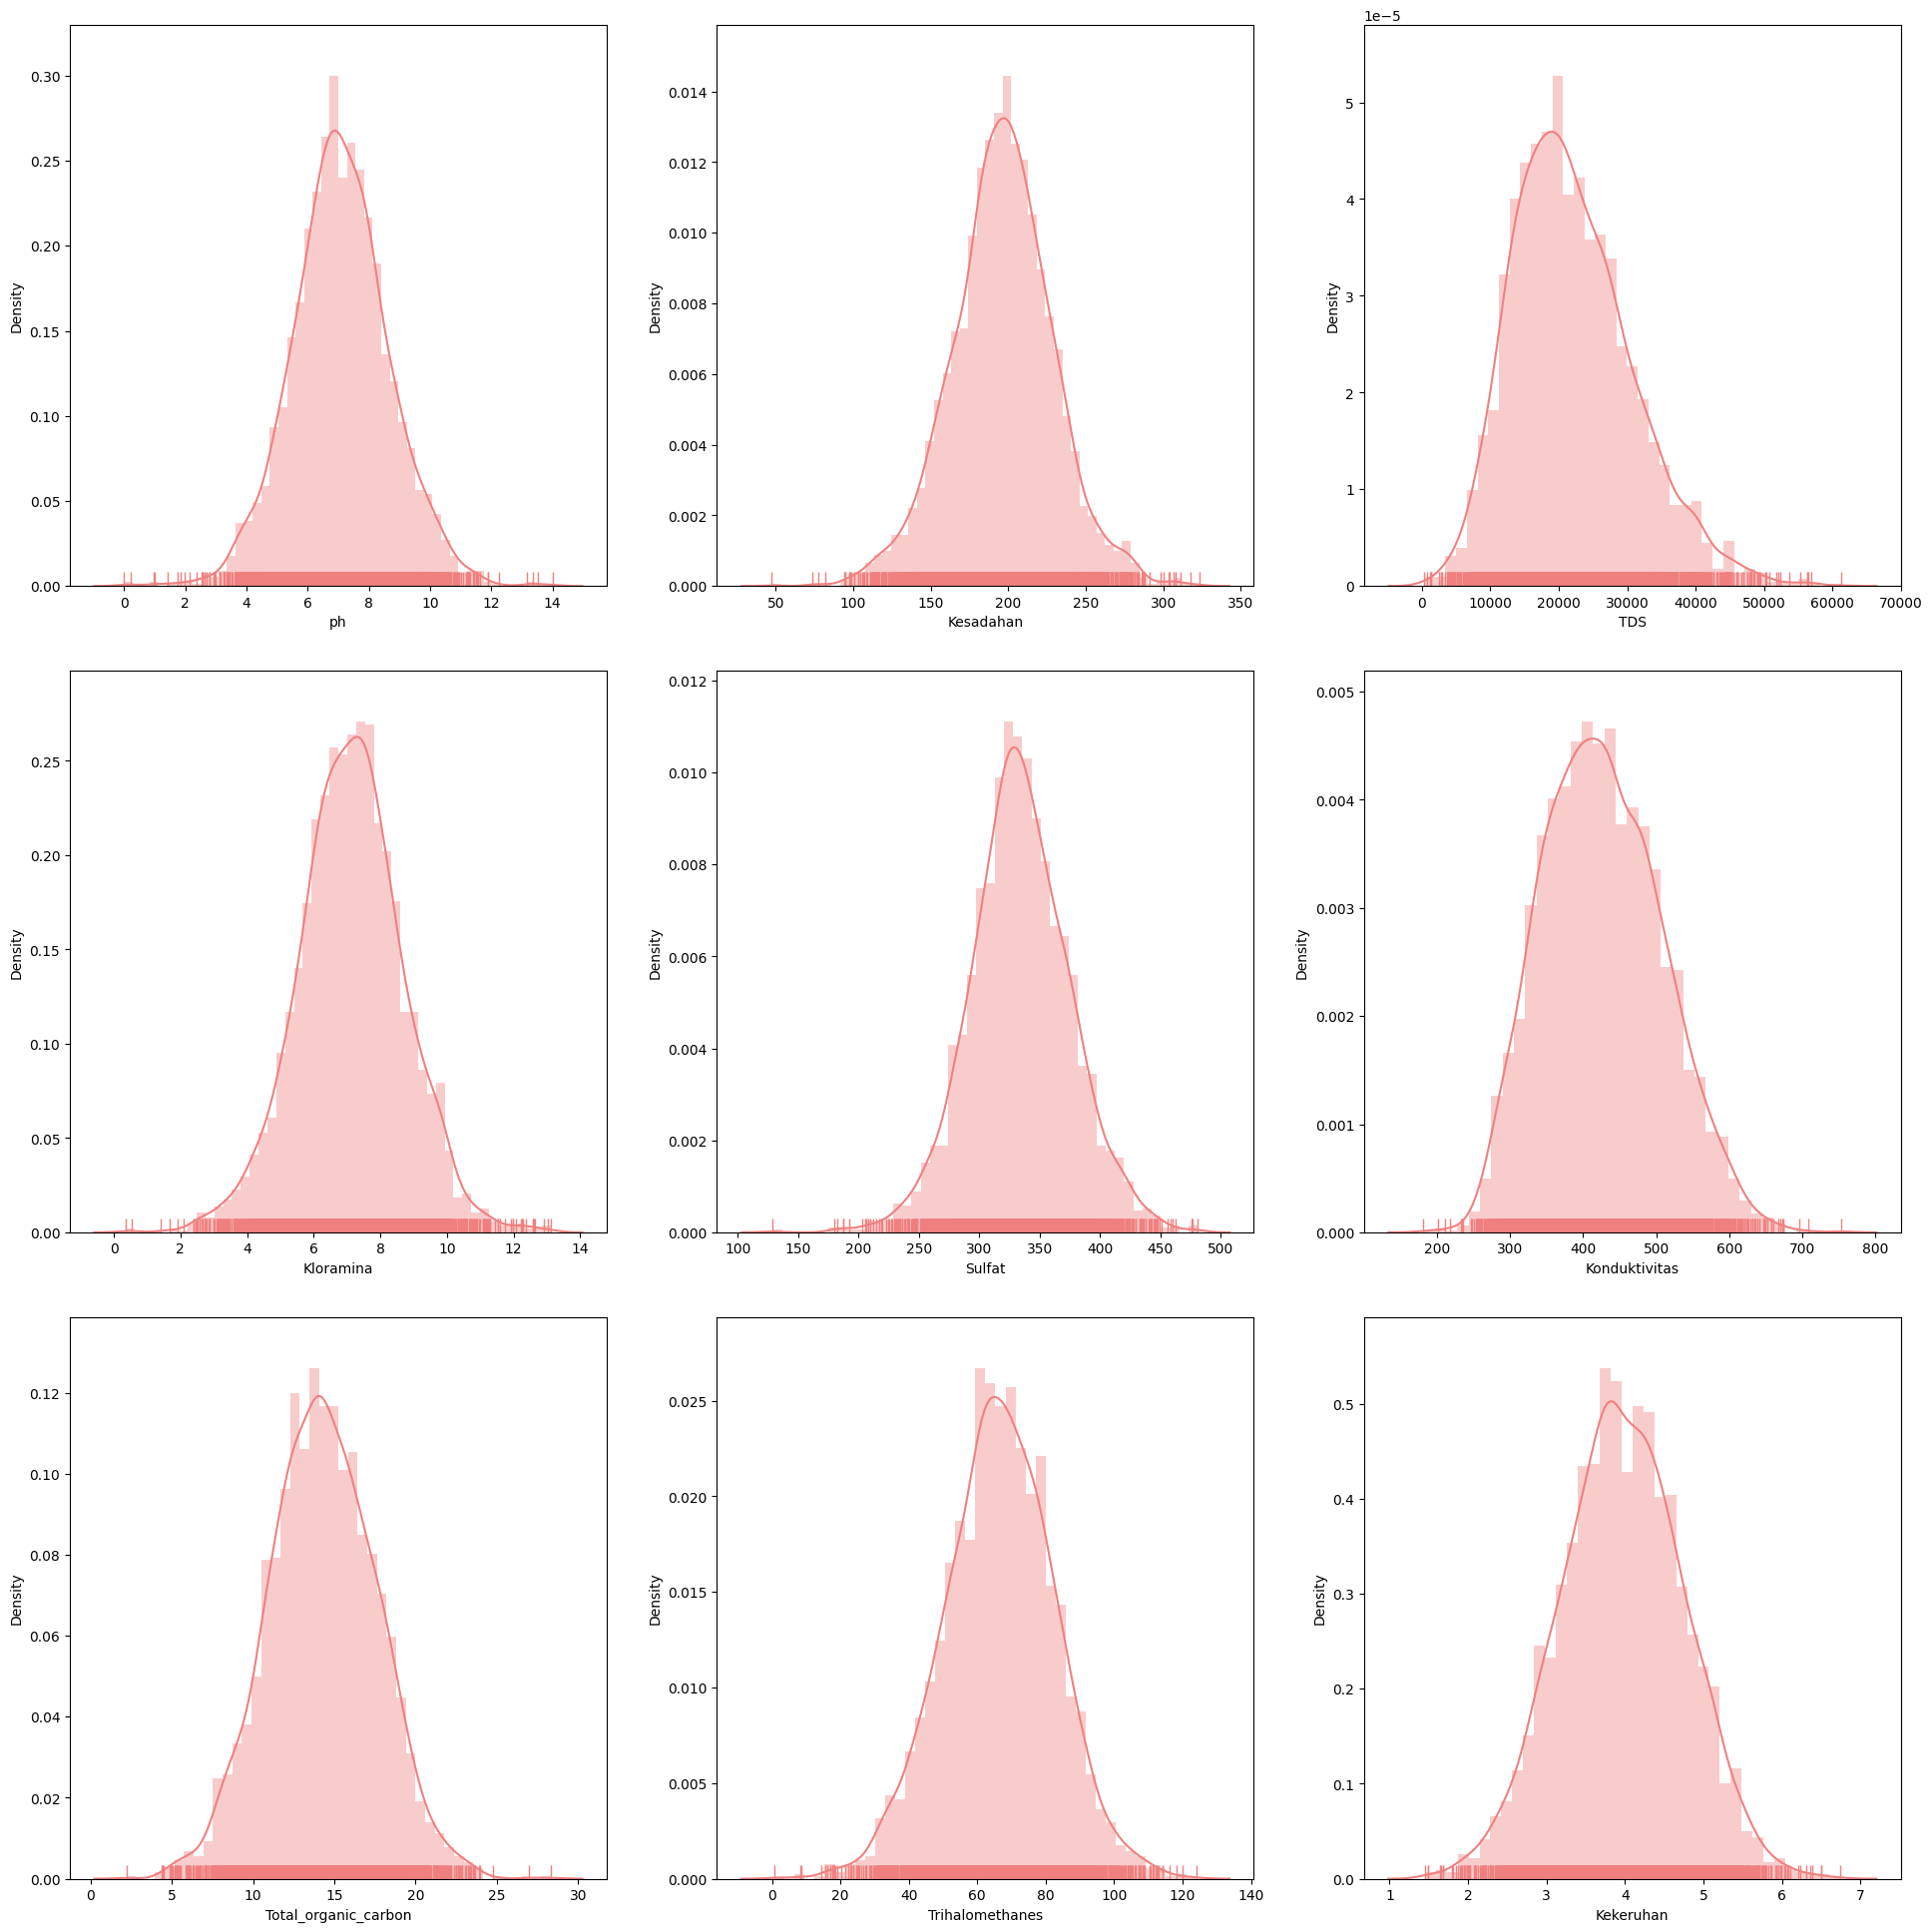

In [17]:
distributionPlot(plot_data)

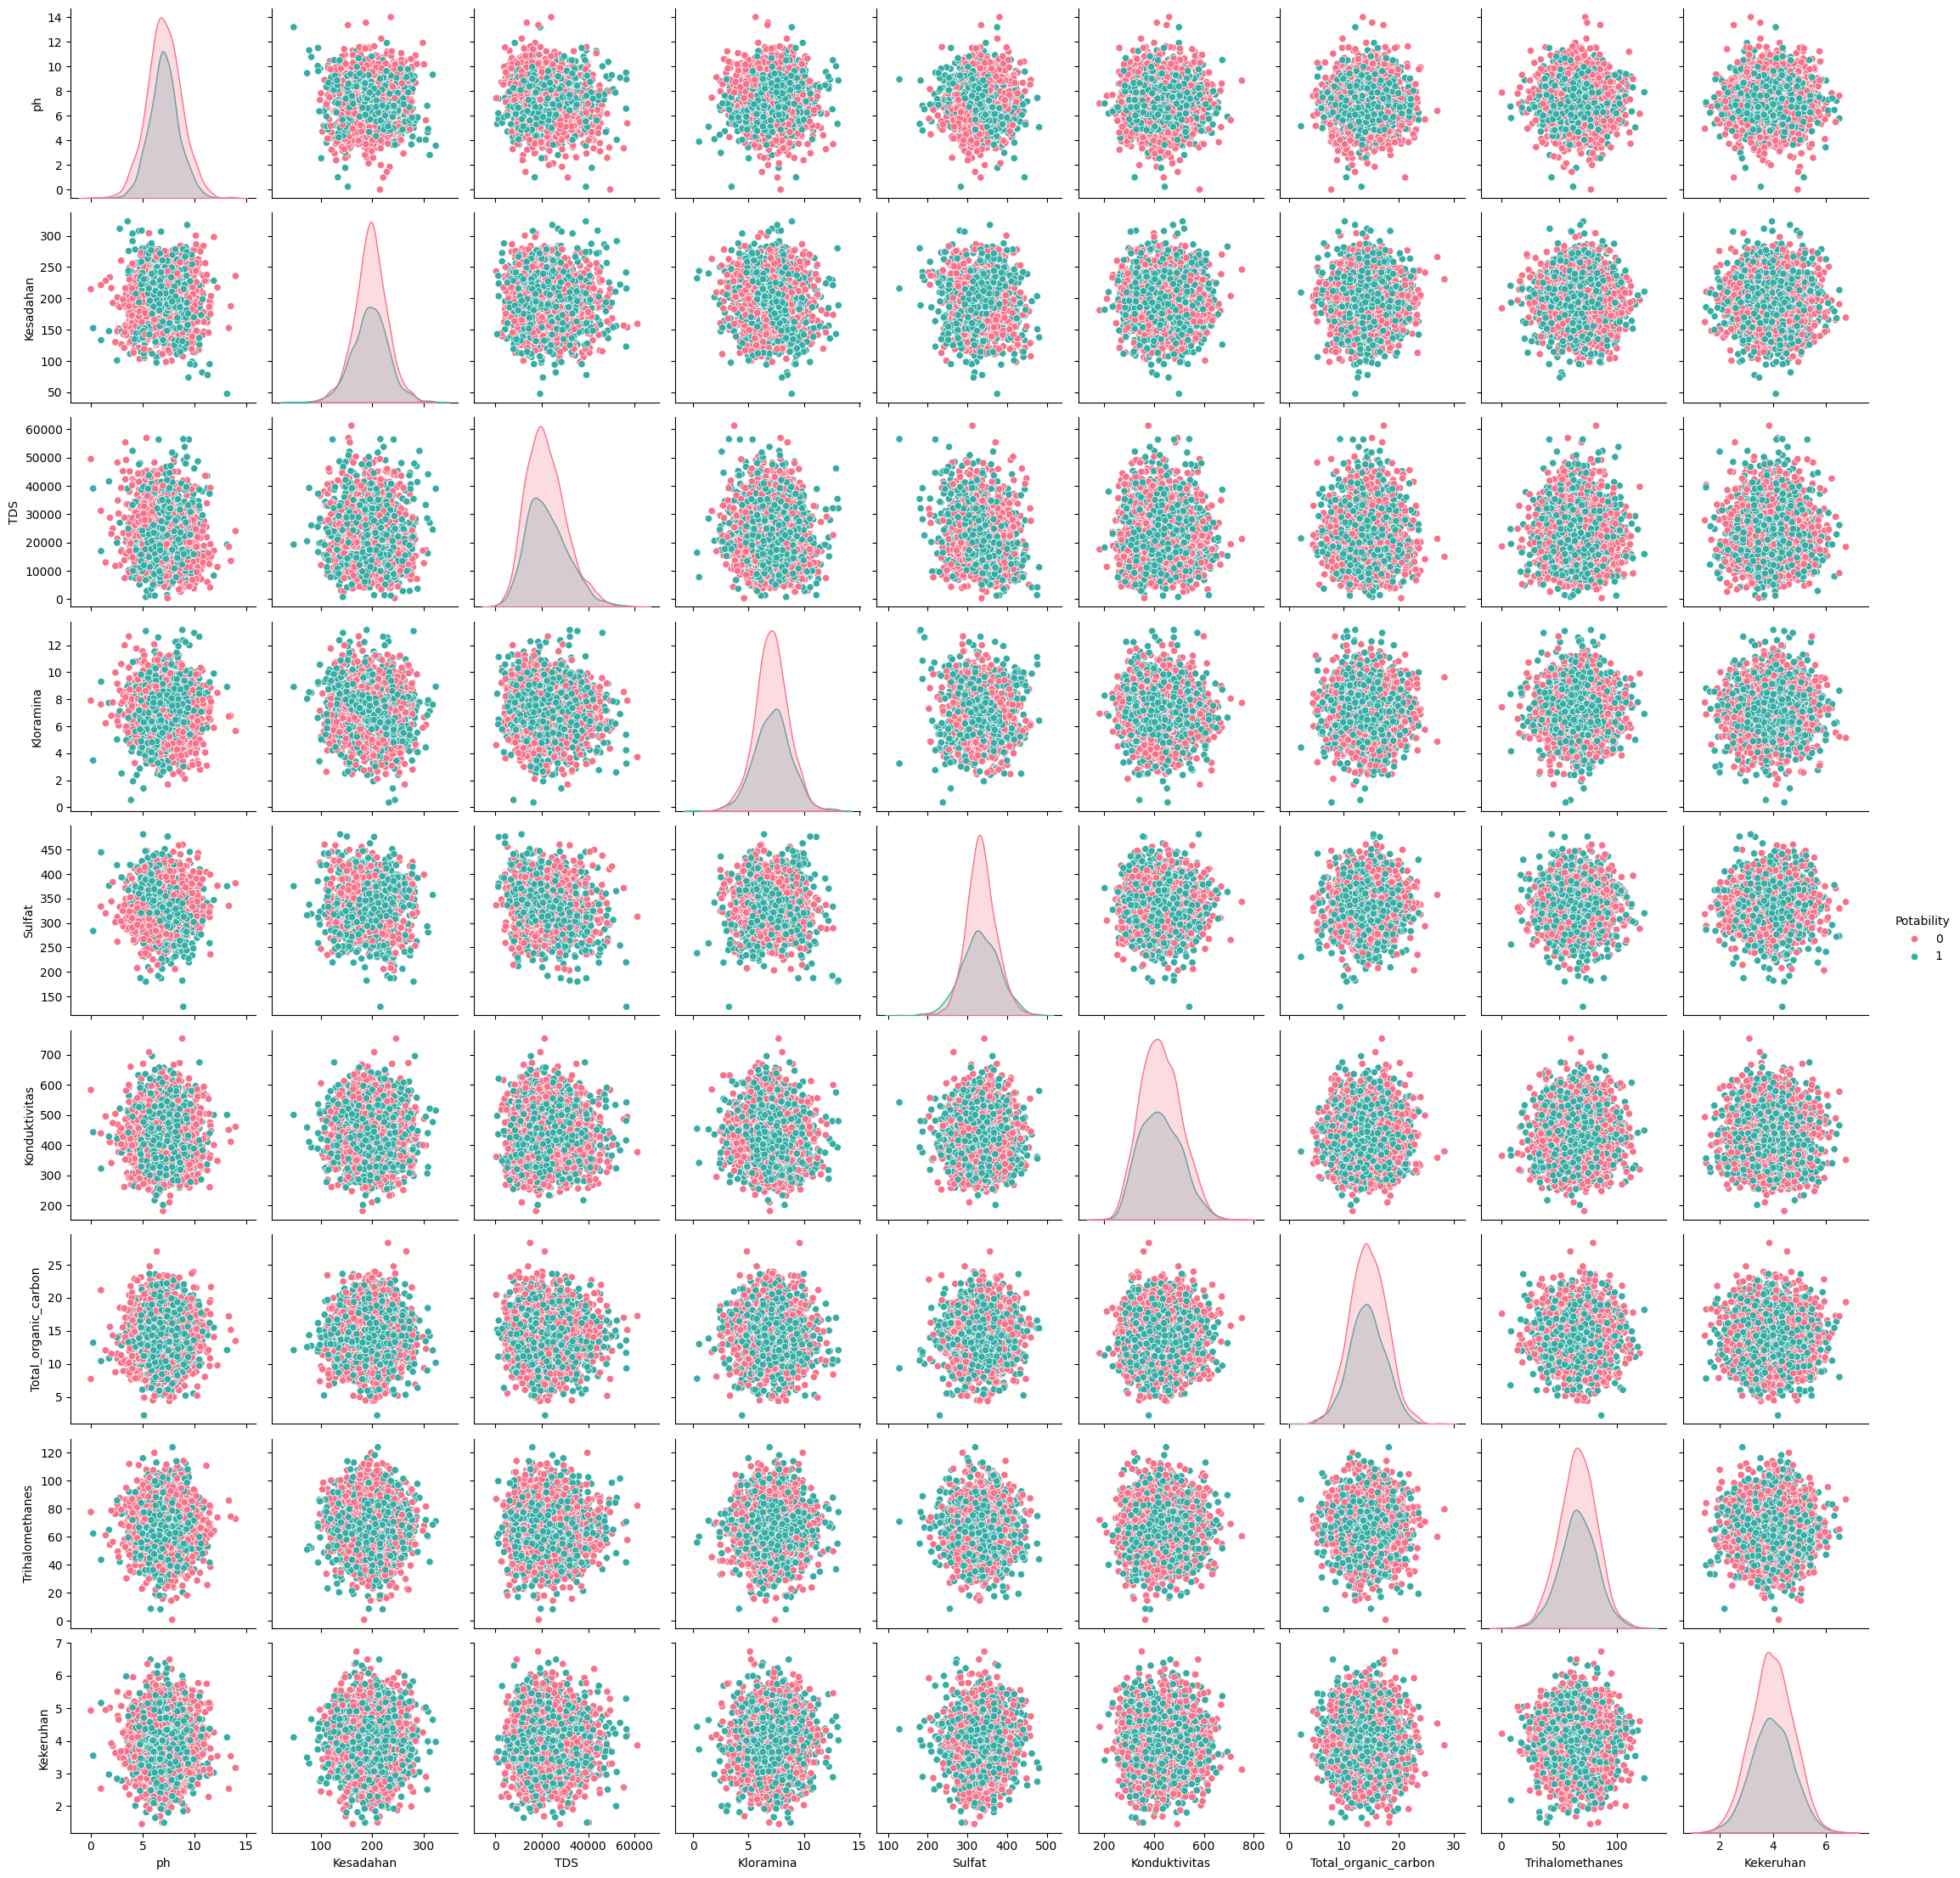

In [18]:
sns.pairplot(df, hue="Potability", palette="husl")

Dari plot-plot diatas, dapat ditentukan:
1. Korelasi antar-fitur rendah
2. Distrubusi normal terlihat dari plot, tidak memiliki kemiringan yang berarti. Bisa dilihat pada bagian 'Menghilangkan Nilai Null pada Dataset' dengan parameter 'skewness'

### Membersihkan Data

#### Menghilangkan Nilai Null pada Dataset

dari dataset diatas pada bagian "Mendapatkan Dataset", kita melihat bahwa dataset df memiliki banyak nilai NaN atau Null yang berarti tidak memiliki nilai. Kita perlu bersihkan nilai-nilai tersebut.

In [19]:
df = df.dropna()

In [20]:
display(df)

ph   Kesadahan           TDS  Kloramina      Sulfat  \
3      8.316766  214.373394  22018.417441   8.059332  356.886136   
4      9.092223  181.101509  17978.986339   6.546600  310.135738   
5      5.584087  188.313324  28748.687739   7.544869  326.678363   
6     10.223862  248.071735  28749.716544   7.513408  393.663396   
7      8.635849  203.361523  13672.091764   4.563009  303.309771   
...         ...         ...           ...        ...         ...   
3267   8.989900  215.047358  15921.412018   6.297312  312.931022   
3268   6.702547  207.321086  17246.920347   7.708117  304.510230   
3269  11.491011   94.812545  37188.826022   9.263166  258.930600   
3270   6.069616  186.659040  26138.780191   7.747547  345.700257   
3271   4.668102  193.681735  47580.991603   7.166639  359.948574   

      Konduktivitas  Total_organic_carbon  Trihalomethanes  Kekeruhan  \
3        363.266516             18.436524       100.341674   4.628771   
4        398.410813             11.558279        31.997993   4.075075   
5        280.467916              8.399735        54.917862   2.559708   
6        283.651634             13.789695        84.603556   2.672989   
7        474.607645             12.363817        62.798309   4.401425   
...             ...                   ...              ...        ...   
3267     390.410231              9.899115        55.069304   4.613843   
3268     329.266002             16.217303        28.878601   3.442983   
3269     439.893618             16.172755        41.558501   4.369264   
3270     415.886955             12.067620        60.419921   3.669712   
3271     526.424171             13.894419        66.687695   4.435821   

      Potability  
3              0  
4              0  
5              0  
6              0  
7              0  
...          ...  
3267           1  
3268           1  
3269           1  
3270           1  
3271           1  

[2011 rows x 10 columns]

In [21]:
df = df.reset_index(drop=True)

In [22]:
display(df)

ph   Kesadahan           TDS  Kloramina      Sulfat  \
0      8.316766  214.373394  22018.417441   8.059332  356.886136   
1      9.092223  181.101509  17978.986339   6.546600  310.135738   
2      5.584087  188.313324  28748.687739   7.544869  326.678363   
3     10.223862  248.071735  28749.716544   7.513408  393.663396   
4      8.635849  203.361523  13672.091764   4.563009  303.309771   
...         ...         ...           ...        ...         ...   
2006   8.989900  215.047358  15921.412018   6.297312  312.931022   
2007   6.702547  207.321086  17246.920347   7.708117  304.510230   
2008  11.491011   94.812545  37188.826022   9.263166  258.930600   
2009   6.069616  186.659040  26138.780191   7.747547  345.700257   
2010   4.668102  193.681735  47580.991603   7.166639  359.948574   

      Konduktivitas  Total_organic_carbon  Trihalomethanes  Kekeruhan  \
0        363.266516             18.436524       100.341674   4.628771   
1        398.410813             11.558279        31.997993   4.075075   
2        280.467916              8.399735        54.917862   2.559708   
3        283.651634             13.789695        84.603556   2.672989   
4        474.607645             12.363817        62.798309   4.401425   
...             ...                   ...              ...        ...   
2006     390.410231              9.899115        55.069304   4.613843   
2007     329.266002             16.217303        28.878601   3.442983   
2008     439.893618             16.172755        41.558501   4.369264   
2009     415.886955             12.067620        60.419921   3.669712   
2010     526.424171             13.894419        66.687695   4.435821   

      Potability  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
2006           1  
2007           1  
2008           1  
2009           1  
2010           1  

[2011 rows x 10 columns]

Panjang dataset disimbolkan sebagai m. Panjang dataset sebelum dan sesudah dibersihkan:
``` json
"m_awal": 3276
"m_akhir": 2011
```

Sehingga banyak baris yang memiliki missing data sebesar 1265.

#### Menghilangkan Nilai Outliers


Outlier(s) bisa didefinisikan secara sederhana adalah nilai yang berbeda dari sebagian besar data pada dataset. Meski data yang berbeda tersebut bersifat data sesungguhnya, namun dapat mempengaruhi pada saat proses latih atau Training untuk model *ANN*.

Metode yang digunakan untuk mendeteksi nilai outlier pada dataset adalah dengan cara melihat nilai skewness

In [23]:
def detect_outliers(df):
    cwo = list()
    df_cols = df.columns.tolist()

    for column in df_cols :
        if type(df[column][0]) == str:
            df_cols.remove(column)

    for col in df_cols :
        skewness = df[col].skew()
        print(f"'{col}' skewness: {skewness}")

        if skewness >= 1 or skewness <= -1:
            cwo.append(col)

    return cwo

def clean_dataset(dataframe):
    df = dataframe
    cwo = detect_outliers(df)

    for o_col in cwo:
        Q1 = df[o_col].quantile(0.25)
        Q3 = df[o_col].quantile(0.75)
        IQR = Q3 - Q1
        whisker_width = 1.5

        outliers = df[(df[o_col] < Q1 - whisker_width*IQR) | (df[o_col] > Q3 + whisker_width*IQR)]
        outlier_values = pd.DataFrame(outliers[o_col])
        outlier_values = outlier_values.values

        col_median = df[o_col].median()

        df[o_col] = df[o_col].replace(to_replace=outlier_values, value=col_median)

In [24]:
outliers = detect_outliers(df)

'ph' skewness: 0.04894678355193392
'Kesadahan' skewness: -0.08523742258053375
'TDS' skewness: 0.5958940107371647
'Kloramina' skewness: 0.012976277458973277
'Sulfat' skewness: -0.04655769698842141
'Konduktivitas' skewness: 0.2668688266945701
'Total_organic_carbon' skewness: -0.020017660786145686
'Trihalomethanes' skewness: -0.051422085759112335
'Kekeruhan' skewness: -0.03305148365834318
'Potability' skewness: 0.39461417218101347


In [25]:
print(outliers)

[]


disimpulkan bahwa pada dataset ini tidak memiliki nilai yang bersifat outlier pada parameter yang akan digunakan.

### Train Test Split

Train Test split adalah proses membagi dataset menjadi train yang digunakan untuk pelatihan dan test yang akan digunakan untuk pengujian model setelah dilatih

In [26]:
def size_testing(dataset_length, test_size, val_size):
    test = round(dataset_length * test_size)
    train = dataset_length - test
    val = round(train * val_size)

    train = train - val

    return (train, test, val)

In [27]:
sz = [0.05, 0.1, 0.2, 0.3, 0.4]

for size in sz:
    print('\n')
    for val_size in sz:
        train, test, val = size_testing(len(df), size, val_size)

        print(f"dataset training size for test size of {size} and validation size of {val_size}: \n\ttrain data: {train}\n\ttest data: {test}\n\tvalidation data: {val}")



dataset training size for test size of 0.05 and validation size of 0.05: 
	train data: 1814
	test data: 101
	validation data: 96
dataset training size for test size of 0.05 and validation size of 0.1: 
	train data: 1719
	test data: 101
	validation data: 191
dataset training size for test size of 0.05 and validation size of 0.2: 
	train data: 1528
	test data: 101
	validation data: 382
dataset training size for test size of 0.05 and validation size of 0.3: 
	train data: 1337
	test data: 101
	validation data: 573
dataset training size for test size of 0.05 and validation size of 0.4: 
	train data: 1146
	test data: 101
	validation data: 764


dataset training size for test size of 0.1 and validation size of 0.05: 
	train data: 1720
	test data: 201
	validation data: 90
dataset training size for test size of 0.1 and validation size of 0.1: 
	train data: 1629
	test data: 201
	validation data: 181
dataset training size for test size of 0.1 and validation size of 0.2: 
	train data: 1448
	test

Pada saat train dan test split, rasio yang akan digunakan untuk data test sebesar 5% dari seluruh data, dan untuk train sebesar 95% dari seluruh data. Dari 95% data train tersebut, 20% akan digunakan untuk proses validasi.

In [28]:
x = df.columns.tolist()
x.remove('Potability')

x = df[x]
y = df.Potability

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=123456789, shuffle=True)

In [30]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [31]:
print(f'jumlah data train: {len(x_train)}')
print(f'jumlah data test: {len(x_test)}')
print(f'jumlah data validation: {len(x_val)}')

jumlah data train: 1528
jumlah data test: 101
jumlah data validation: 382


### Seleksi Fitur

In [32]:
num_feats = ["ph","Kesadahan","TDS","Kloramina","Sulfat",
             "Konduktivitas","Total_organic_carbon","Trihalomethanes","Kekeruhan"]

pre = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler())
    ]), num_feats)
])

clf = Pipeline([
    ("pre", pre),
    ("gb", GradientBoostingClassifier(random_state=42))
])

clf.fit(x_train, y_train)

y_pred_prob = clf.predict_proba(x_test)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

result = permutation_importance(
    clf, x_test, y_test,
    n_repeats=20, random_state=42, n_jobs=-1, scoring="roc_auc"
)

importance_df = pd.DataFrame({
    "feature": num_feats,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

print("\nPermutation Importance (sorted):")
print(importance_df)

ROC-AUC: 0.6294903926482875

Permutation Importance (sorted):
                feature  importance_mean  importance_std
4                Sulfat         0.102736        0.039006
0                    ph         0.079741        0.042601
3             Kloramina         0.031516        0.019564
1             Kesadahan         0.027193        0.012485
5         Konduktivitas         0.002694        0.014848
6  Total_organic_carbon         0.000710        0.013559
7       Trihalomethanes        -0.012322        0.012463
8             Kekeruhan        -0.014056        0.014603
2                   TDS        -0.026003        0.020880


Dari data diatas, fitur sebaiknya dipertahankan jika importance_mean > importance_std.
Nilai ROC-AUC model = 0.66, sehingga model dapat menangkap pola dalam data meski lemah.
Maka dari itu, parameter yang akan dihilangkan secara pasti adalah Kekeruhan, Konduktivitas, Trihalomethanes, TOC, TDS.

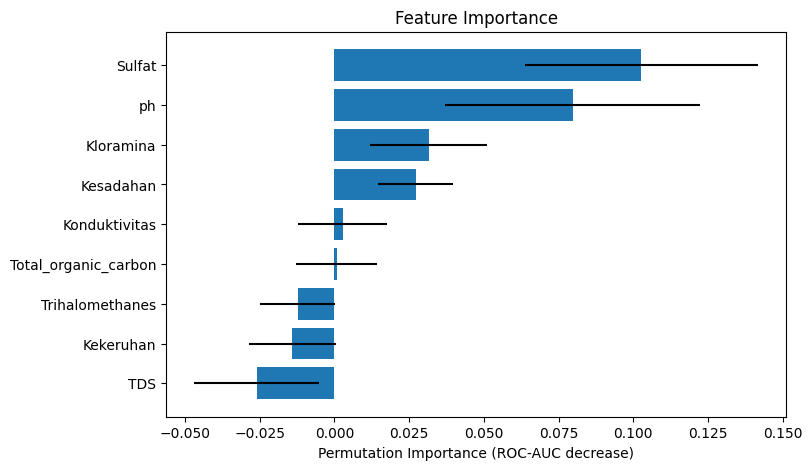

In [33]:
plt.figure(figsize=(8,5))
plt.barh(importance_df["feature"], importance_df["importance_mean"], xerr=importance_df["importance_std"])
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance (ROC-AUC decrease)")
plt.title("Feature Importance")
plt.show()

In [34]:
import shap

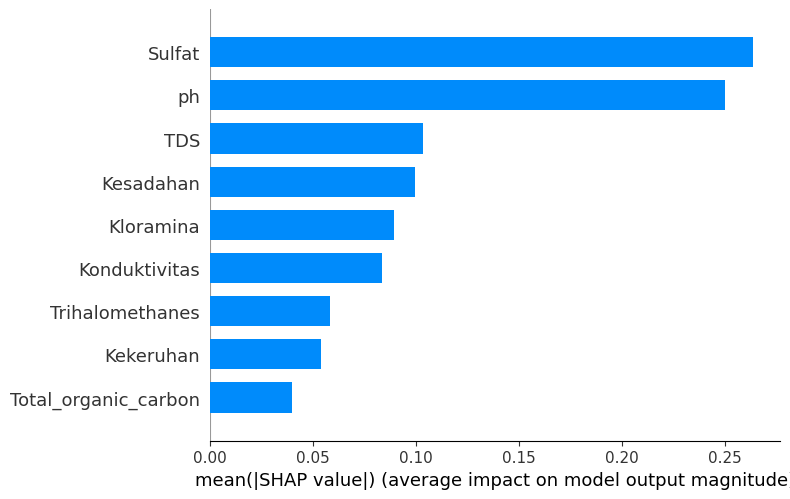

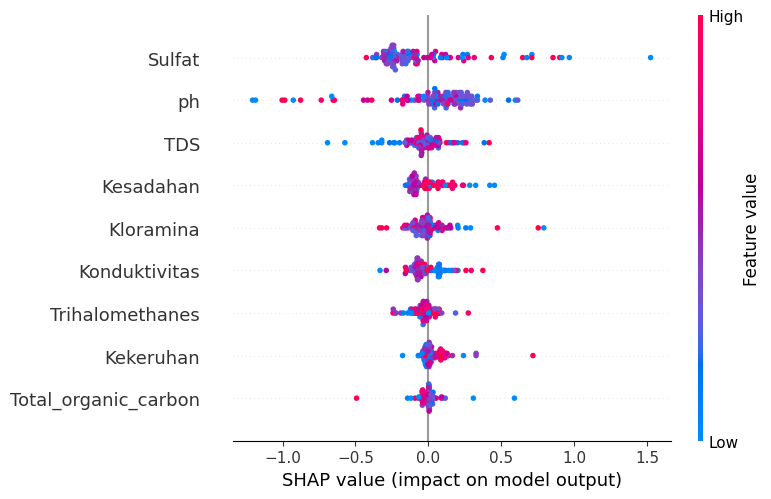

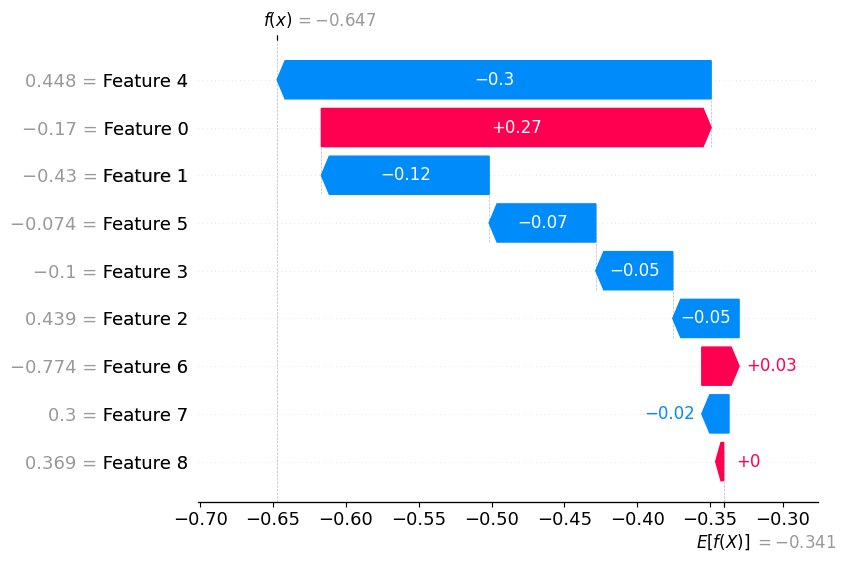

In [35]:
explainer = shap.Explainer(clf.named_steps["gb"], pre.fit_transform(x_train))

shap_values = explainer(pre.transform(x_test))

shap.summary_plot(shap_values, x_test, feature_names=num_feats, plot_type="bar")
shap.summary_plot(shap_values, x_test, feature_names=num_feats)

sample_index = 0
shap.plots.waterfall(shap_values[sample_index])

In [36]:
x_train.head()

ph   Kesadahan           TDS  Kloramina      Sulfat  \
430    6.436444  192.995665  19579.389546   7.640874  314.922739   
1066   5.999125  219.716109  19345.791332   6.029641  264.285069   
1314   7.272362  229.087141  16404.759485   7.589754  272.276912   
896    8.163074  162.231846  10494.573369   8.087496  423.952028   
1905  11.449739  186.652648  12355.344107   7.065576  321.831513   

      Konduktivitas  Total_organic_carbon  Trihalomethanes  Kekeruhan  
430      379.675367             12.897049        75.839132   3.415851  
1066     497.477151             16.381195        46.303523   5.046973  
1314     518.609480             17.878956        67.104417   3.996581  
896      487.318346             16.011608        69.976719   4.128193  
1905     503.964110             16.282371        77.152173   5.166903

In [37]:
dropped = ['Kloramina', 'Trihalomethanes', 'Total_organic_carbon']

x_train_fs = x_train.drop(dropped, axis=1)
x_test_fs = x_test.drop(dropped, axis=1)
x_val_fs = x_val.drop(dropped, axis=1)

In [38]:
display(x_train_fs, x_test_fs, x_val_fs)

ph   Kesadahan           TDS      Sulfat  Konduktivitas  \
430    6.436444  192.995665  19579.389546  314.922739     379.675367   
1066   5.999125  219.716109  19345.791332  264.285069     497.477151   
1314   7.272362  229.087141  16404.759485  272.276912     518.609480   
896    8.163074  162.231846  10494.573369  423.952028     487.318346   
1905  11.449739  186.652648  12355.344107  321.831513     503.964110   
...         ...         ...           ...         ...            ...   
956    7.033945  246.622871  15428.450916  305.616422     516.217847   
980    6.917858  200.705505  27651.609099  321.696455     453.637510   
1538   7.338108  188.854169  30042.928506  309.614560     465.499871   
1332   8.180755  178.079638  25623.867503  391.918229     353.507014   
762    2.690831  151.782906  30204.546735  303.702409     377.198273   

      Kekeruhan  
430    3.415851  
1066   5.046973  
1314   3.996581  
896    4.128193  
1905   5.166903  
...         ...  
956    3.931731  
980    5.544167  
1538   3.736380  
1332   3.845423  
762    4.650034  

[1528 rows x 6 columns]

ph   Kesadahan           TDS      Sulfat  Konduktivitas  \
936    6.788292  182.036895  25661.360539  352.344929     419.895888   
1372  10.391942  262.741770  39116.682706  285.728420     473.313969   
1736   8.594217  228.160901  29706.234224  257.148650     517.844674   
246    7.146976  196.562685  16911.203773  320.100875     520.111358   
402    7.143942  153.236364  11553.039281  329.404457     278.483266   
...         ...         ...           ...         ...            ...   
313    6.624806  204.342928  21443.264749  312.315229     412.996763   
422    8.842464  229.964422   7839.318760  278.428265     370.085153   
1677   6.857494  233.210575  22603.649454  368.105783     412.434677   
478   11.898078  228.132673   8296.550611  346.649750     500.169210   
256    6.945224  220.960041  36438.310876  337.963891     367.997977   

      Kekeruhan  
936    4.255948  
1372   5.771715  
1736   4.489545  
246    4.025762  
402    3.792840  
...         ...  
313    2.840911  
422    4.576729  
1677   4.306581  
478    3.024968  
256    4.823082  

[101 rows x 6 columns]

ph   Kesadahan           TDS      Sulfat  Konduktivitas  Kekeruhan
1574  6.238054  178.298051  21919.593435  335.858369     287.572947   3.848307
1097  6.152858  171.125287  24978.483177  323.824376     406.094427   4.403083
824   2.569244  201.603284  48204.172192  261.719960     429.746430   5.506934
1653  7.117579  186.199680  31528.948690  335.348881     380.578265   4.333402
52    6.953372  203.146547  11609.109055  304.283193     551.143337   3.651866
...        ...         ...           ...         ...            ...        ...
1787  6.106760  211.454489  39430.307823  348.776719     389.591440   3.924967
147   4.723313  252.274895  22833.192042  378.560304     411.295025   3.917587
1402  6.756660  212.641858  22112.746346  275.240444     387.562192   4.184874
335   7.286167  208.444085  30879.026684  336.048832     352.602146   4.686020
1527  9.012100  268.679299  13064.450591  358.336760     549.827142   4.962329

[382 rows x 6 columns]

## Membangun Arsitektur Model Artificial Neural Network

### Membuat Baseline Model

Dalam pembuatan model neural network, sangat disarankan membuat baseline model sebagai tolak ukur minimum dan juga apakah model kompleks seperti neural network layak digunakan.

In [ ]:
ac = dict()

#### Algoritma Support Vector Machine (SVM)

In [ ]:
svm_pipe = Pipeline([
    ('scalar', StandardScaler()),
    ('svm', SVC(gamma='scale'))
])

svm_grid = {
    'svm__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'svm__kernel': ['rbf', 'linear']
}

svm_gs = GridSearchCV(svm_pipe, svm_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_gs.fit(x_train_fs, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'svm__kernel': ['rbf', 'linear']},
             scoring='accuracy')

In [ ]:
print(svm_gs.best_params_)
print(svm_gs.best_score_)

{'svm__C': 1, 'svm__kernel': 'rbf'}
0.6884753026893817


In [ ]:
svm_pipe.fit(x_train_fs, y_train)

y_pred = svm_pipe.predict(x_test_fs)

In [ ]:
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred))

Akurasi: 0.693069306930693
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.70      0.89      0.78        63
           1       0.67      0.37      0.47        38

    accuracy                           0.69       101
   macro avg       0.68      0.63      0.63       101
weighted avg       0.69      0.69      0.67       101



In [ ]:
ac['svm'] = accuracy_score(y_test, y_pred)

Setelah mencoba 3 algoritma yang berbeda, maka yang akan digunakan sebagai baseline model adalah algoritma RandomForestClassifier dengan akurasi sebesar 71% dengan data latih.

#### Algoritma Logistic Regression

In [ ]:
logres_pipe = Pipeline([
    ('scalar', StandardScaler()),
    ('logres', LogisticRegression(solver='liblinear', max_iter=1000))
])

logres_grid = {
    'logres__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logres__penalty': ['l1', 'l2']
}

logres_gs = GridSearchCV(logres_pipe, logres_grid, cv=5, scoring='accuracy', n_jobs=-1)
logres_gs.fit(x_train_fs, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('logres',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logres__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'logres__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [ ]:
print(logres_gs.best_params_)
print(logres_gs.best_score_)

{'logres__C': 0.001, 'logres__penalty': 'l1'}
0.6001307189542484


In [ ]:
logres_pipe.fit(x_train_fs, y_train)

y_pred = logres_pipe.predict(x_test_fs)

In [ ]:
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred))

Akurasi: 0.6138613861386139
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.62      0.98      0.76        63
           1       0.00      0.00      0.00        38

    accuracy                           0.61       101
   macro avg       0.31      0.49      0.38       101
weighted avg       0.39      0.61      0.47       101



In [ ]:
ac['logres'] = accuracy_score(y_test, y_pred)

#### Algoritma RandomForestClassifier

In [ ]:
rf_pipe = Pipeline([
    ('scalar', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

rf_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

rf_gs = GridSearchCV(rf_pipe, rf_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_gs.fit(x_train_fs, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 20],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [100, 200]},
             scoring='accuracy')

In [ ]:
print(rf_gs.best_params_)
print(rf_gs.best_score_)

{'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
0.676712739740705


In [ ]:
rf_pipe.fit(x_train_fs, y_train)

y_pred = rf_pipe.predict(x_test_fs)

In [ ]:
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred))

Akurasi: 0.6633663366336634
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.70      0.79      0.75        63
           1       0.57      0.45      0.50        38

    accuracy                           0.66       101
   macro avg       0.64      0.62      0.62       101
weighted avg       0.65      0.66      0.65       101



In [ ]:
ac['randomforest'] = accuracy_score(y_test, y_pred)

#### Algoritma XGBoost

In [ ]:
xgb_pipe = Pipeline([
    ('scalar', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(xgb_pipe, xgb_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(x_train_fs, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:36:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_poli...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [3, 5],
                         'xgb__n_estimators': [100, 200],
                         'xgb__subsample': [0.8, 1.0]},
             scoring='accuracy')

In [ ]:
print(xgb_grid.best_params_)
print(xgb_grid.best_score_)

{'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
0.6766977392049716


In [ ]:
xgb_pipe.fit(x_train_fs, y_train)

y_pred = xgb_pipe.predict(x_test_fs)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:36:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred))

Akurasi: 0.5742574257425742
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.65      0.70      0.67        63
           1       0.42      0.37      0.39        38

    accuracy                           0.57       101
   macro avg       0.54      0.53      0.53       101
weighted avg       0.56      0.57      0.57       101



In [ ]:
ac['xgb'] = accuracy_score(y_test, y_pred)

In [ ]:
ac_percent = list()

for x in ac.values():
    ac_percent.append(f'{round(x, 3)*100}%')

In [ ]:
ac_df = pd.DataFrame(ac_percent, index=ac.keys(), columns=['accuracy'])
display(ac_df)

accuracy
svm             69.3%
logres          61.4%
randomforest    66.3%
xgb             57.4%

### Neural Network

#### Normalisasi Fitur

Normalisasi feature pertujuan agar setiap feature memiliki skala yang sama, hal ini dilakukan karena model neural network sensitif terhadap skala.

Normalisasi feature merubah agar setiap feature memiliki nilai mean=0 dan standard deviation=1.

In [50]:
import joblib

In [52]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train_fs)
x_val = scaler.transform(x_val_fs)

In [53]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [51]:
x_test_nn = scaler.transform(x_test_fs)

In [42]:
display(x_test_fs)

ph   Kesadahan           TDS      Sulfat  Konduktivitas  \
936    6.788292  182.036895  25661.360539  352.344929     419.895888   
1372  10.391942  262.741770  39116.682706  285.728420     473.313969   
1736   8.594217  228.160901  29706.234224  257.148650     517.844674   
246    7.146976  196.562685  16911.203773  320.100875     520.111358   
402    7.143942  153.236364  11553.039281  329.404457     278.483266   
...         ...         ...           ...         ...            ...   
313    6.624806  204.342928  21443.264749  312.315229     412.996763   
422    8.842464  229.964422   7839.318760  278.428265     370.085153   
1677   6.857494  233.210575  22603.649454  368.105783     412.434677   
478   11.898078  228.132673   8296.550611  346.649750     500.169210   
256    6.945224  220.960041  36438.310876  337.963891     367.997977   

      Kekeruhan  
936    4.255948  
1372   5.771715  
1736   4.489545  
246    4.025762  
402    3.792840  
...         ...  
313    2.840911  
422    4.576729  
1677   4.306581  
478    3.024968  
256    4.823082  

[101 rows x 6 columns]

#### Callbacks dalam Pelatihan

In [ ]:
class nn_acc(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get("val_accuracy")>0.9):
            print("\nAccuracy >= 90%!")
            self.model.stop_training = True

class nn_mse(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get("mse")<0.001):
            self.model.stop_training = True

stop = nn_acc()
stop2 = nn_mse()

#### Model 1 (hyperparameter-tuning)
{
    dense1,
    dropout,
    dense2,
    dropout,
    denseoutput
}

In [48]:
def build_model(units1=128, units2=64, dropout=0.3, l2_reg=0.001, lr=0.001):
    model = Sequential()
    model.add(Dense(units1, input_dim=x_train.shape[1], activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)))
    model.add(Dropout(dropout))
    model.add(Dense(units2, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
dropouts = [0.2, 0.3]
units1_list = [64, 128]
units2_list = [32, 64]
l2_regs = [0.001, 0.0005]
lrs = [0.001, 0.0005]

best_acc = 0
best_params = {}

for d in dropouts:
    for u1 in units1_list:
        for u2 in units2_list:
            for reg in l2_regs:
                for lr in lrs:
                    model = build_model(units1=u1, units2=u2, dropout=d, l2_reg=reg, lr=lr)
                    history = model.fit(
                        x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=50,
                        batch_size=32,
                        verbose=0
                    )
                    y_pred = (model.predict(x_test_nn) > 0.5).astype(int)
                    acc = accuracy_score(y_test, y_pred)
                    print(f"[manual] acc={acc:.4f} | u1={u1}, u2={u2}, d={d}, reg={reg}, lr={lr}")

                    if acc > best_acc:
                        best_acc = acc
                        best_params = {"units1": u1, "units2": u2, "dropout": d, "l2": reg, "lr": lr}

                    if acc >= 0.7:
                        model.save(f'model1_{best_params}-{acc}.keras')
                        print(f'saved model!')

print("\n🔍 Best Manual Accuracy: {:.2f}%".format(best_acc * 100))
print("Best Manual Params:", best_params)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[manual] acc=0.6535 | u1=64, u2=32, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[manual] acc=0.6634 | u1=64, u2=32, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[manual] acc=0.6535 | u1=64, u2=32, d=0.2, reg=0.0005, lr=0.001
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[manual] acc=0.6634 | u1=64, u2=32, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[manual] acc=0.6634 | u1=64, u2=64, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[manual] acc=0.6733 | u1=64, u2=64, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[manual] acc=0.6832 | u1=64, u2=64, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[manual] acc=0.6634 | u1=64, u2=64, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[manual] acc=0.6337 | u1=128, u2=32, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[manual] acc=0.6634 | u1=128, u2=32, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6634 | u1=128, u2=32, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6634 | u1=128, u2=32, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[manual] acc=0.6634 | u1=128, u2=64, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6733 | u1=128, u2=64, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[manual] acc=0.6634 | u1=128, u2=64, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[manual] acc=0.6634 | u1=128, u2=64, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6436 | u1=64, u2=32, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[manual] acc=0.6832 | u1=64, u2=32, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[manual] acc=0.6733 | u1=64, u2=32, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[manual] acc=0.6832 | u1=64, u2=32, d=0.3, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[manual] acc=0.6931 | u1=64, u2=64, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[manual] acc=0.6634 | u1=64, u2=64, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6634 | u1=64, u2=64, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[manual] acc=0.6436 | u1=64, u2=64, d=0.3, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[manual] acc=0.6436 | u1=128, u2=32, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[manual] acc=0.6436 | u1=128, u2=32, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[manual] acc=0.6535 | u1=128, u2=32, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[manual] acc=0.6436 | u1=128, u2=32, d=0.3, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[manual] acc=0.6832 | u1=128, u2=64, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6931 | u1=128, u2=64, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[manual] acc=0.6436 | u1=128, u2=64, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6436 | u1=128, u2=64, d=0.3, reg=0.0005, lr=0.0005

🔍 Best Manual Accuracy: 69.31%
Best Manual Params: {'units1': 64, 'units2': 64, 'dropout': 0.3, 'l2': 0.001, 'lr': 0.001}


#### Model 2 (hyperparameter-tuning)
{
    dense1,
    dense1,
    dropout,
    dense2,
    denseoutput
}

In [52]:
def build_model2(units1=128, units2=64, dropout=0.3, l2_reg=0.001, lr=0.001):
    model = Sequential()
    model.add(Dense(units1, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(units1, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)))
    model.add(Dropout(dropout))
    model.add(Dense(units2, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [53]:
model = build_model2()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,729 (100.50 KB)

 Trainable params: 25,729 (100.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
dropouts = [0.2, 0.3]
units1_list = [64, 128, 256]
units2_list = [32, 64]
l2_regs = [0.001, 0.0005]
lrs = [0.001, 0.0005]

best_acc = 0
best_params = {}

for d in dropouts:
    for u1 in units1_list:
        for u2 in units2_list:
            for reg in l2_regs:
                for lr in lrs:
                    model2 = build_model2(units1=u1, units2=u2, dropout=d, l2_reg=reg, lr=lr)
                    history2 = model2.fit(
                        x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=50,
                        batch_size=32,
                        verbose=0
                    )
                    y_pred = (model2.predict(x_test_nn) > 0.5).astype(int)
                    acc = accuracy_score(y_test, y_pred)
                    print(f'[manual] acc={acc:.4f} | u1={u1}, u2={u2}, d={d}, reg={reg}, lr={lr}')

                    if acc > best_acc:
                        best_acc = acc
                        best_params = {'units1': u1, 'units2': u2, 'dropout': d, 'l2': reg, 'lr': lr}

                    if acc >= 0.7:
                        model2.save(f'model2_{best_params}-{acc}.keras')
                        print(f'saved model!')

print('\n🔍 Best Manual Accuracy: {:.2f}%'.format(best_acc * 100))
print('Best Manual Params:', best_params)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6931 | u1=64, u2=32, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[manual] acc=0.6634 | u1=64, u2=32, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6733 | u1=64, u2=32, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6337 | u1=64, u2=32, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6931 | u1=64, u2=64, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6535 | u1=64, u2=64, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6436 | u1=64, u2=64, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6337 | u1=64, u2=64, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[manual] acc=0.6436 | u1=128, u2=32, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6139 | u1=128, u2=32, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6535 | u1=128, u2=32, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6832 | u1=128, u2=32, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[manual] acc=0.6337 | u1=128, u2=64, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6040 | u1=128, u2=64, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6040 | u1=128, u2=64, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6040 | u1=128, u2=64, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6337 | u1=256, u2=32, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.5842 | u1=256, u2=32, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6238 | u1=256, u2=32, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6139 | u1=256, u2=32, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[manual] acc=0.6337 | u1=256, u2=64, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6139 | u1=256, u2=64, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6733 | u1=256, u2=64, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6436 | u1=256, u2=64, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[manual] acc=0.6139 | u1=64, u2=32, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6238 | u1=64, u2=32, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6535 | u1=64, u2=32, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6238 | u1=64, u2=32, d=0.3, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6337 | u1=64, u2=64, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[manual] acc=0.6634 | u1=64, u2=64, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[manual] acc=0.6832 | u1=64, u2=64, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[manual] acc=0.6634 | u1=64, u2=64, d=0.3, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[manual] acc=0.6634 | u1=128, u2=32, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[manual] acc=0.6139 | u1=128, u2=32, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[manual] acc=0.6535 | u1=128, u2=32, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6535 | u1=128, u2=32, d=0.3, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[manual] acc=0.6238 | u1=128, u2=64, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.5941 | u1=128, u2=64, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[manual] acc=0.6436 | u1=128, u2=64, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[manual] acc=0.6238 | u1=128, u2=64, d=0.3, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[manual] acc=0.6139 | u1=256, u2=32, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[manual] acc=0.6040 | u1=256, u2=32, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[manual] acc=0.6535 | u1=256, u2=32, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[manual] acc=0.6535 | u1=256, u2=32, d=0.3, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6535 | u1=256, u2=64, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6535 | u1=256, u2=64, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6436 | u1=256, u2=64, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[manual] acc=0.6337 | u1=256, u2=64, d=0.3, reg=0.0005, lr=0.0005

🔍 Best Manual Accuracy: 69.31%
Best Manual Params: {'units1': 64, 'units2': 32, 'dropout': 0.2, 'l2': 0.001, 'lr': 0.001}


#### Model 3 (hyperparameter-tuning)
{
    dense1,
    dense1,
    dense2,
    dropout,
    denseoutput
}

In [ ]:
def build_model3(units1=128, units2=64, dropout=0.3, l2_reg=0.001, lr=0.001):
    model = Sequential()

    model.add(Dense(units1, input_dim=x_train.shape[1], activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)))
    model.add(Dense(units1, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)))
    model.add(Dense(units2, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
dropouts = [0.2, 0.3, 0.5]
units1_list = [64, 128, 256]
units2_list = [32, 64]
l2_regs = [0.001, 0.0005]
lrs = [0.001, 0.0005]

best_acc = 0
best_params = {}

for d in dropouts:
    for u1 in units1_list:
        for u2 in units2_list:
            for reg in l2_regs:
                for lr in lrs:
                    model3 = build_model3(units1=u1, units2=u2, dropout=d, l2_reg=reg, lr=lr)
                    history3 = model3.fit(
                        x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=50,
                        batch_size=32,
                        verbose=0
                    )
                    y_pred = (model3.predict(x_test_nn) > 0.5).astype(int)
                    acc = accuracy_score(y_test, y_pred)
                    print(f"[manual] acc={acc:.4f} | u1={u1}, u2={u2}, d={d}, reg={reg}, lr={lr}")

                    if acc > best_acc:
                        best_acc = acc
                        best_params = {"units1": u1, "units2": u2, "dropout": d, "l2": reg, "lr": lr}

                    if acc >= 0.7:
                        model3.save(f'model3_{best_params}-{acc}.keras')
                        print(f'saved model!')

print("\n🔍 Best Manual Accuracy: {:.2f}%".format(best_acc * 100))
print("Best Manual Params:", best_params)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6535 | u1=64, u2=32, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6634 | u1=64, u2=32, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[manual] acc=0.6238 | u1=64, u2=32, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6139 | u1=64, u2=32, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6535 | u1=64, u2=64, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[manual] acc=0.6238 | u1=64, u2=64, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6139 | u1=64, u2=64, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[manual] acc=0.6733 | u1=64, u2=64, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[manual] acc=0.6931 | u1=128, u2=32, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6733 | u1=128, u2=32, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.5842 | u1=128, u2=32, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6733 | u1=128, u2=32, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[manual] acc=0.6931 | u1=128, u2=64, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6535 | u1=128, u2=64, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[manual] acc=0.5941 | u1=128, u2=64, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[manual] acc=0.6238 | u1=128, u2=64, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[manual] acc=0.7129 | u1=256, u2=32, d=0.2, reg=0.001, lr=0.001
saved model!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.5941 | u1=256, u2=32, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6436 | u1=256, u2=32, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.5743 | u1=256, u2=32, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.5842 | u1=256, u2=64, d=0.2, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6436 | u1=256, u2=64, d=0.2, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[manual] acc=0.6535 | u1=256, u2=64, d=0.2, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[manual] acc=0.6040 | u1=256, u2=64, d=0.2, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6535 | u1=64, u2=32, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.5941 | u1=64, u2=32, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[manual] acc=0.6535 | u1=64, u2=32, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6535 | u1=64, u2=32, d=0.3, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6733 | u1=64, u2=64, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[manual] acc=0.6931 | u1=64, u2=64, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6238 | u1=64, u2=64, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.5941 | u1=64, u2=64, d=0.3, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6040 | u1=128, u2=32, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6139 | u1=128, u2=32, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[manual] acc=0.6238 | u1=128, u2=32, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6436 | u1=128, u2=32, d=0.3, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[manual] acc=0.6436 | u1=128, u2=64, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[manual] acc=0.6436 | u1=128, u2=64, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6535 | u1=128, u2=64, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[manual] acc=0.6139 | u1=128, u2=64, d=0.3, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[manual] acc=0.6832 | u1=256, u2=32, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[manual] acc=0.6436 | u1=256, u2=32, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[manual] acc=0.6337 | u1=256, u2=32, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[manual] acc=0.6733 | u1=256, u2=32, d=0.3, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[manual] acc=0.6436 | u1=256, u2=64, d=0.3, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[manual] acc=0.6337 | u1=256, u2=64, d=0.3, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6337 | u1=256, u2=64, d=0.3, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[manual] acc=0.6634 | u1=256, u2=64, d=0.3, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[manual] acc=0.6337 | u1=64, u2=32, d=0.5, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[manual] acc=0.6337 | u1=64, u2=32, d=0.5, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6832 | u1=64, u2=32, d=0.5, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6436 | u1=64, u2=32, d=0.5, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[manual] acc=0.6436 | u1=64, u2=64, d=0.5, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6436 | u1=64, u2=64, d=0.5, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6436 | u1=64, u2=64, d=0.5, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[manual] acc=0.6337 | u1=64, u2=64, d=0.5, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[manual] acc=0.6040 | u1=128, u2=32, d=0.5, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6634 | u1=128, u2=32, d=0.5, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[manual] acc=0.6931 | u1=128, u2=32, d=0.5, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6337 | u1=128, u2=32, d=0.5, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6634 | u1=128, u2=64, d=0.5, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6337 | u1=128, u2=64, d=0.5, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6832 | u1=128, u2=64, d=0.5, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[manual] acc=0.5743 | u1=128, u2=64, d=0.5, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[manual] acc=0.6139 | u1=256, u2=32, d=0.5, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[manual] acc=0.5941 | u1=256, u2=32, d=0.5, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[manual] acc=0.6634 | u1=256, u2=32, d=0.5, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6634 | u1=256, u2=32, d=0.5, reg=0.0005, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6634 | u1=256, u2=64, d=0.5, reg=0.001, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[manual] acc=0.6040 | u1=256, u2=64, d=0.5, reg=0.001, lr=0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[manual] acc=0.5743 | u1=256, u2=64, d=0.5, reg=0.0005, lr=0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[manual] acc=0.6337 | u1=256, u2=64, d=0.5, reg=0.0005, lr=0.0005

🔍 Best Manual Accuracy: 71.29%
Best Manual Params: {'units1': 256, 'units2': 32, 'dropout': 0.2, 'l2': 0.001, 'lr': 0.001}


### Evaluasi
model3_{'units1'_ 256, 'units2'_ 32, 'dropout'_ 0.2, 'l2'_ 0.001, 'lr'_ 0.001}-0.7128712871287128

In [ ]:
dt = files.upload()

Saving model3_{'units1'_ 256, 'units2'_ 32, 'dropout'_ 0.2, 'l2'_ 0.001, 'lr'_ 0.001}-0.7128712871287128.keras to model3_{'units1'_ 256, 'units2'_ 32, 'dropout'_ 0.2, 'l2'_ 0.001, 'lr'_ 0.001}-0.7128712871287128.keras


In [ ]:
model_alpha = load_model("/content/model3_{'units1'_ 256, 'units2'_ 32, 'dropout'_ 0.2, 'l2'_ 0.001, 'lr'_ 0.001}-0.7128712871287128.keras")

Model: "sequential_310"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1208 (Dense)              │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1209 (Dense)              │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1210 (Dense)              │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_342 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1211 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,525 (888.77 KB)

 Trainable params: 75,841 (296.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 151,684 (592.52 KB)

None


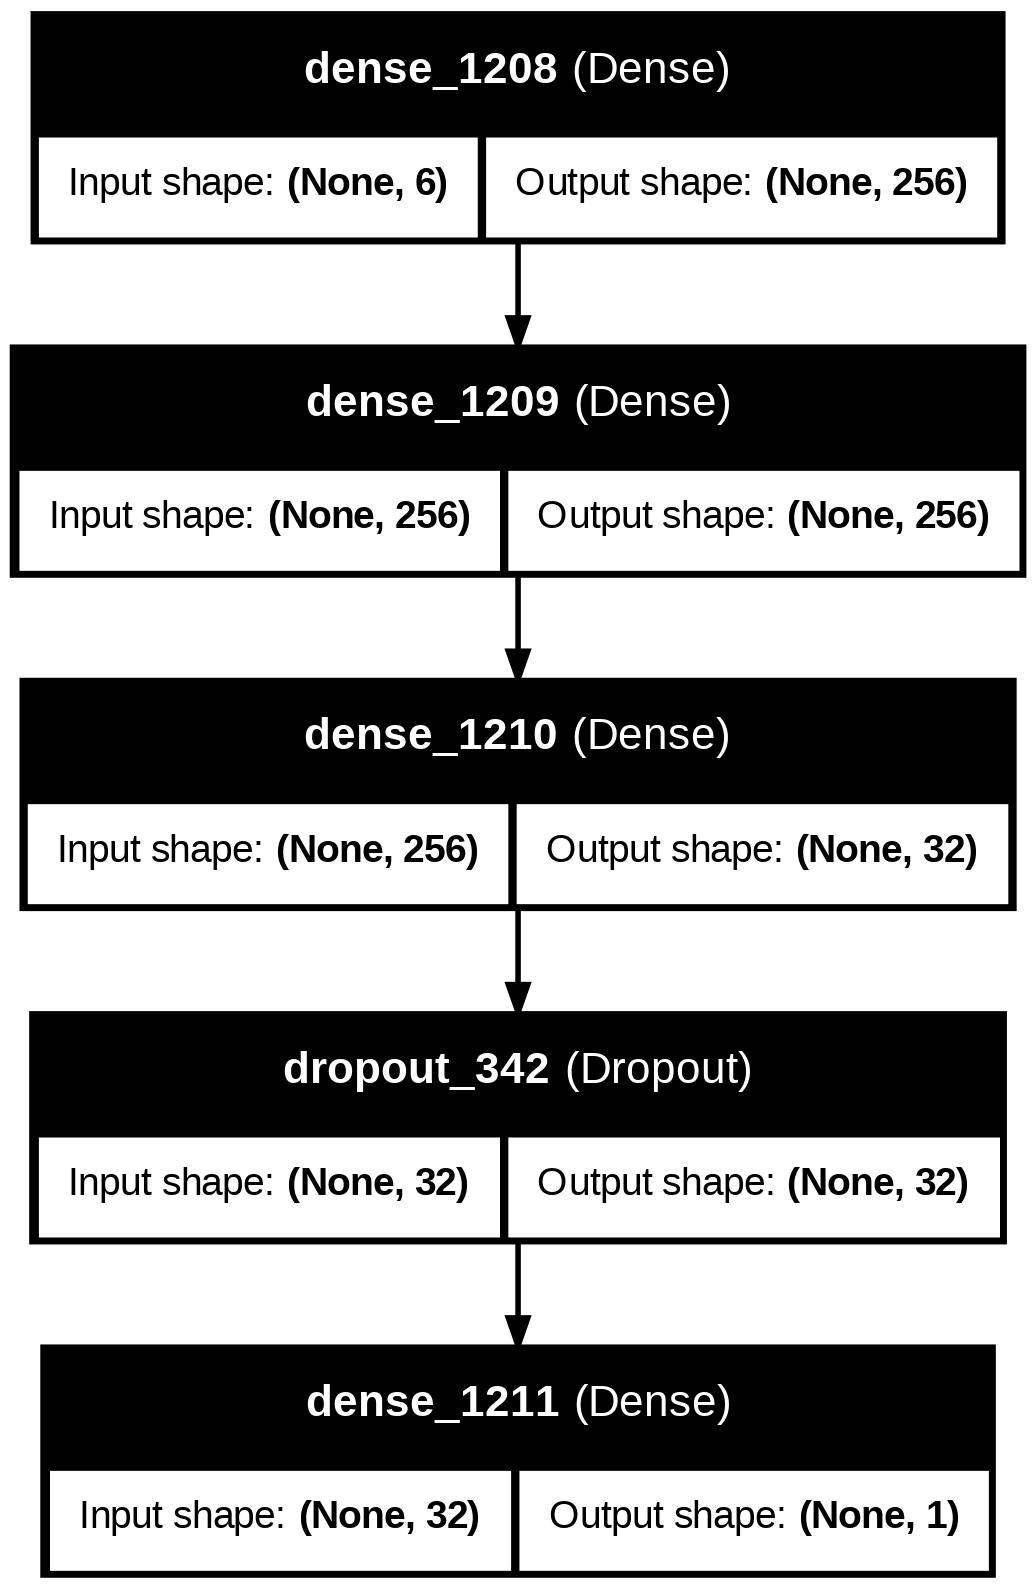

In [ ]:
print(model_alpha.summary())
plot_model(model_alpha, to_file="architecture_alpha.png", show_shapes=True, show_layer_names=True)

In [ ]:
y_pred = (model_alpha.predict(x_test_nn) > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


In [49]:
x_test_nn

array([[-1.92649693e-01, -4.15570615e-01,  4.26851583e-01,
         4.73441703e-01, -5.73842834e-02,  3.75505955e-01],
       [ 2.11800568e+00,  1.99567857e+00,  2.17384970e+00,
        -1.15221672e+00,  6.19470640e-01,  2.47996753e+00],
       [ 9.65307077e-01,  9.62493227e-01,  9.52025683e-01,
        -1.84965558e+00,  1.18371456e+00,  6.99826904e-01],
       [ 3.73383953e-02,  1.84217220e-02, -7.09242165e-01,
        -3.13417562e-01,  1.21243548e+00,  5.59199094e-02],
       [ 3.53928029e-02, -1.27605465e+00, -1.40492995e+00,
        -8.63800668e-02, -1.84920887e+00, -2.67464481e-01],
       [-7.99180174e-01,  6.38739054e-01,  9.44051017e-01,
        -1.08356049e-01, -1.44009211e+00, -1.66868408e-01],
       [-8.39593930e-02,  6.95958776e-01, -2.80205141e-01,
        -6.41726276e-01,  8.80113775e-02,  8.36166871e-01],
       [ 1.07115088e-01,  1.26013409e-01,  1.32710986e+00,
        -2.04807586e-01,  8.21675218e-01, -2.40302049e-02],
       [ 1.74092862e-02, -6.69062470e-02, -5.076

In [ ]:
print(classification_report(y_test, y_pred, target_names=['not potable', 'potable']))

              precision    recall  f1-score   support

 not potable       0.74      0.84      0.79        63
     potable       0.66      0.50      0.57        38

    accuracy                           0.71       101
   macro avg       0.70      0.67      0.68       101
weighted avg       0.71      0.71      0.70       101



In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79        63
           1       0.66      0.50      0.57        38

    accuracy                           0.71       101
   macro avg       0.70      0.67      0.68       101
weighted avg       0.71      0.71      0.70       101

